<a href="https://colab.research.google.com/github/rimosoma/ML_for_healt/blob/main/lab6healt_fastica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Laboratory 6: ICA on Artificial Signals and EEG (Extended)
Reference: slide_lab6.pdf

This script extends the professor's 'fastica_artificial.py'.

Contents:
1. Artificial Example :
   - Generates 4 non-Gaussian signals.
   - Mixes them using a random matrix A.
   - Recovers them using FastICA.
   - Compares with PCA.

"""

import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA, PCA
from matplotlib.pyplot import cm
import os


=== PART 1: ARTIFICIAL ICA EXAMPLE ===


Text(0.5, 0, 't (s)')

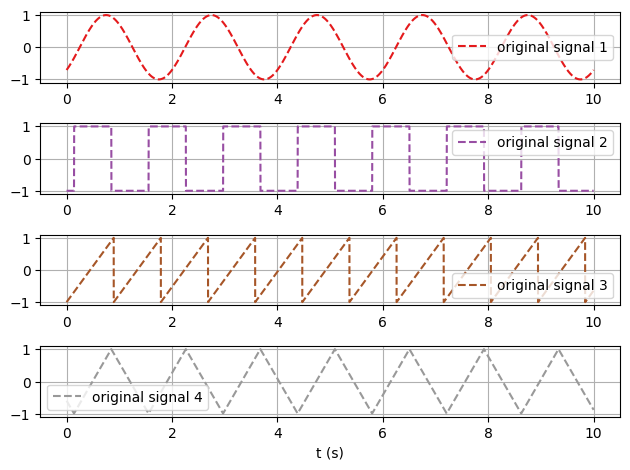

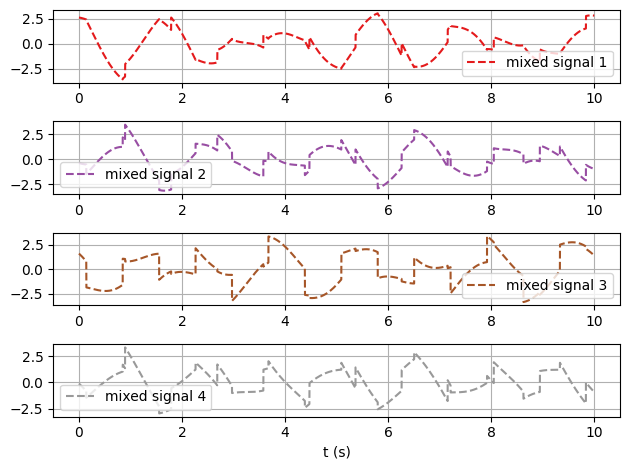

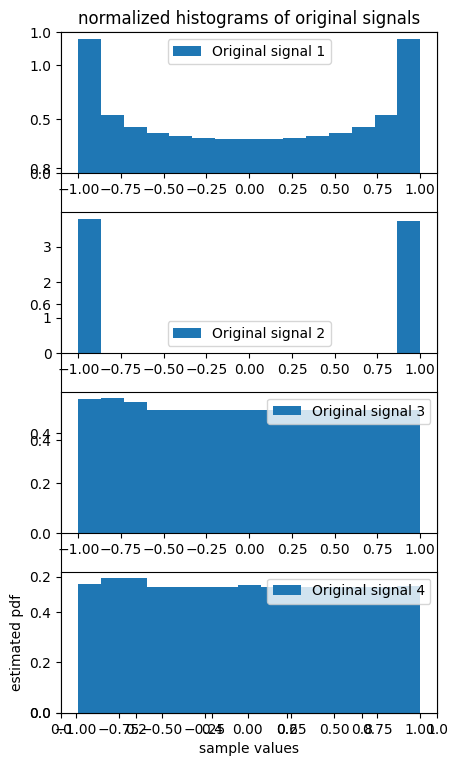

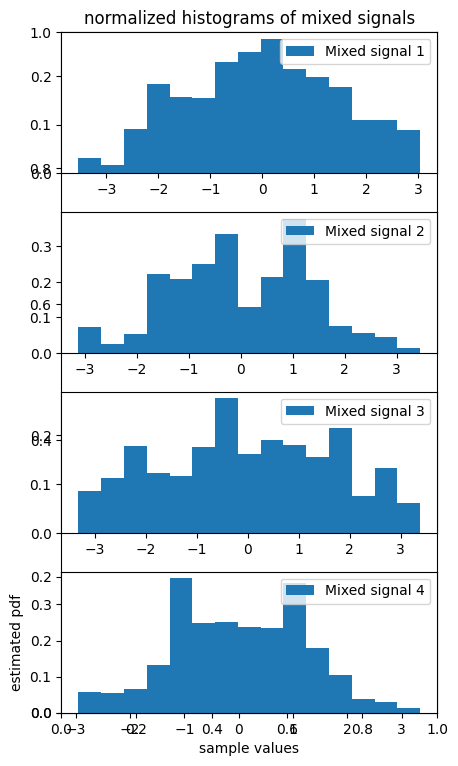

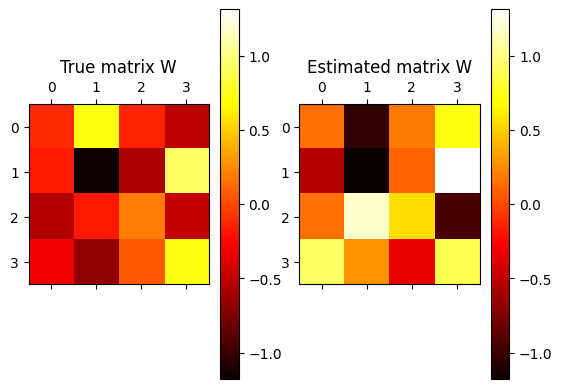

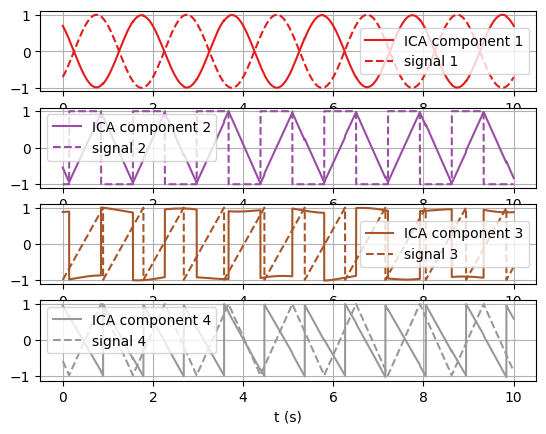

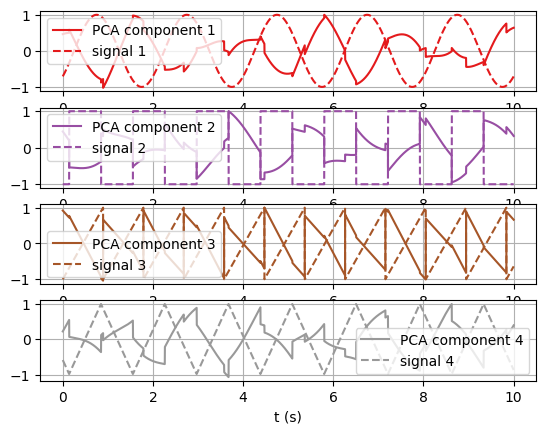

In [2]:
# --- PART 1: ARTIFICIAL EXAMPLE (PROFESSOR'S CODE PRESERVED) ---
# See Slide 25-32
print("=== PART 1: ARTIFICIAL ICA EXAMPLE ===")

np.random.seed(50)  # set the seed to reproduce the experiment

plt.close('all')

#%% Generate the artificial signals
"""
Here we prepare the "ingredients" to test the ICA algorithm.
Think of this as a recipe: we need to create 4 distinct, pure signals that we will
later mix together to see if the ICA can separate them back out.

THE KEY REQUIREMENT: Non-Gaussianity
To reverse the mixing, ICA looks for components that are the *least* Gaussian.
Therefore, our ingredients must have probability density functions (pdfs)
that are as different from a Gaussian bell curve as possible.

The Ingredients List:
1. x1 (Sinusoid):
   A standard periodic signal. It serves as a control. Its pdf is U-shaped
   (bounded), not Gaussian, but less "sharp" than the others.

2. x2 (Square Wave) - The "Holy Grail" for ICA:
   Generated by taking the sign of a sinusoid. This is ideal for ICA because
   its pdf is discrete (only min and max values exist). It has negative kurtosis
   and is extremely non-Gaussian.

3. x3 (Sawtooth Wave):
   Generated using scipy.signal. It has a uniform pdf (flat distribution),
   which is very distinct from a Gaussian bell curve.

4. x4 (Triangular Wave):
   Created by integrating ('cumsum') the square wave x2.
   - Why integrate? The integral of a square wave is a triangle.
   - Processing steps:
     a. Standardization: (x - mean) / std -> Centers the signal and scales energy.
     b. Scaling: / max -> Normalizes amplitude to range [-1, 1].
     c. Resizing: Matches matrix dimensions.
   Like the sawtooth, this has a uniform pdf[cite: 252].

Technical Note on Frequencies:
We use irrational multipliers (sqrt(2), sqrt(5)) for frequencies. This ensures
the signals are "incommensurable" (they never align perfectly), guaranteeing
statistical independence, which is the second requirement for ICA.
"""
N = 10000 # number opf samples
N_signals=4 # number of signals
t = np.linspace(0, 10, N) # generate the time axis (seconds)
t.resize(1,N)
freq1 = 0.5 # main frequency (Hz)
freq2 = freq1*np.sqrt(2)
freq3 = freq1*np.sqrt(5)
x1 = np.sin(2*np.pi*freq1* t-np.pi/4)  # Signal 1: sinusoidal signal
x2 = np.sign(np.sin(2*np.pi*freq2* t-np.pi/5))  # Signal 2: square wave
x3 = signal.sawtooth(2*np.pi*freq3* t)  # Signal 3: saw tooth signal
x4=np.cumsum(x2)
x4=(x4-x4.mean())/x4.std()
x4=x4/x4.max()
x4.resize(1,N) # signal 2: triangular signal
t=t.flatten()
# if you want to see what happens with signals having Gaussian pdf
# x4=np.random.randn(1,N)
# x4=x4/x4.max()
# x3=np.random.randn(1,N)
# x3=x3/x3.max()



X = np.concatenate((x1,x2,x3,x4),axis=0) # shape: 4 rows N columns
color = iter(cm.Set1(np.linspace(0, 1,N_signals)))
plt.figure()# plots of the original signals
for n in range(N_signals):
    c = next(color)
    plt.subplot(N_signals,1,1+n)
    plt.plot(t,X[n,:],'--',color=c,label='original signal '+str(n+1))
    plt.grid()
    plt.legend()
plt.xlabel('t (s)')
plt.tight_layout()

#%% Generate the observed/mixed signals
A = np.random.randn(N_signals,N_signals)  # true weight matrix (random)
Y = np.dot(A,X)  # observed/mixed signals, shape: 4 rows N columns
W = np.linalg.inv(A)
color = iter(cm.Set1(np.linspace(0, 1,N_signals)))
plt.figure()# plots of the mixed signals
for n in range(N_signals):
    c = next(color)
    plt.subplot(N_signals,1,1+n)
    plt.plot(t,Y[n,:],'--',color=c,label='mixed signal '+str(n+1))
    plt.grid()
    plt.legend()
plt.xlabel('t (s)')
plt.tight_layout()
#%% reshape
X=X.T #shape: N rows, 4 columns
Y=Y.T #shape: N rows, 4 columns


#%% look at the pdfs
plt.figure(figsize=(5,8))# histograms
Nbins = np.ceil(1+np.log2(N)).astype(int)
plt.title('normalized histograms of original signals')
for n in range(N_signals):
    plt.subplot(N_signals,1,1+n)
    plt.hist(X[:,n],bins=Nbins,density=True,label='Original signal '+str(n+1))
    plt.legend()
plt.xlabel('sample values')
plt.ylabel('estimated pdf')
plt.tight_layout()
plt.figure(figsize=(5,8))
plt.title('normalized histograms of mixed signals')
for n in range(N_signals):
    plt.subplot(N_signals,1,1+n)
    plt.hist(Y[:,n],bins=Nbins,density=True,label='Mixed signal '+str(n+1))
    plt.legend()
plt.xlabel('sample values')
plt.ylabel('estimated pdf')
plt.tight_layout()


#%% Use FastICA
ica = FastICA(n_components=N_signals,algorithm="deflation", whiten="unit-variance")
XhatICA = ica.fit_transform(Y)  # Reconstruct indep signals from obervations
Ahat = ica.mixing_  # estimated A
What = ica.components_ # estimated matrix W: Xhat=np.dot(Y,ica.components_.T)

vm1=W.min()
VM1=W.max()
vm2=What.min()
VM2=What.max()
vm=np.min([vm1,vm2])
VM=np.max([VM1,VM2])

plt.figure()
plt.subplot(1,2,1)
plt.matshow(W,0,vmin=vm,vmax=VM, cmap='hot')
plt.colorbar()
plt.title('True matrix W')
plt.subplot(1,2,2)
plt.matshow(What,0,vmin=vm,vmax=VM, cmap='hot')
plt.colorbar()
plt.title('Estimated matrix W')


#%% Use also PCA
pca = PCA(n_components=N_signals)
XhatPCA = pca.fit_transform(Y)  # Reconstruct signals based on orthogonal components


#%% Plot the results
color = iter(cm.Set1(np.linspace(0, 1,N_signals)))
plt.figure()
for n in range(N_signals):
    c = next(color)
    plt.subplot(N_signals,1,1+n)
    plt.plot(t,XhatICA[:,n]/np.max(XhatICA[:,n]),'-',color=c,label='ICA component '+str(n+1))
    plt.plot(t,X[:,n]/np.max(X[:,n]),'--',color=c,label='signal '+str(n+1))
    plt.grid()
    plt.legend()
plt.xlabel('t (s)')
color = iter(cm.Set1(np.linspace(0, 1,N_signals)))
plt.figure()
for n in range(N_signals):
    c = next(color)
    plt.subplot(N_signals,1,1+n)
    plt.plot(t,XhatPCA[:,n]/np.max(XhatPCA[:,n]),'-',color=c,label='PCA component '+str(n+1))
    plt.plot(t,X[:,n]/np.max(X[:,n]),'--',color=c,label='signal '+str(n+1))
    plt.grid()
    plt.legend()
plt.xlabel('t (s)')